# Patchs zonées

On vas experimenter sur des modèles basés sur les comatrices. Pour chaque image on applique des patchs de manière équitable si possible. Aussi, on évitera de faire la moyenne sur les données reçues dans chaque patchs pour ne pas "étouffer" les valeurs recueillies par des patchs en sous effectifs dans leur ensemble.

In [1]:
# OUTILS
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy

from sklearn.utils import shuffle

path_mer = "../Data/mer/"
path_ailleurs = "../Data/Ailleurs/"

QUANTIZATION_FACTOR = 4

In [2]:
def img_format(image):
    convert_matrix = (1, 0, 0, 0,
                      0, 1, 0, 0,
                      0, 0, 1, 0)
    return image.resize((700, 700)).convert('RGB').convert('RGB', matrix=convert_matrix)

# Application des patchs

On vas appliquer K patchs de taille PATCH_SIZE sur nos images. Les données seront donc une liste avec K relevés pour chaque images.

In [3]:
def get_patch_coordinates(w, h, n_target, p_size):
    '''
    Calcul les coordonnées d'application de chaque patch pour obtenir une répartition la plus équitable possible
    '''
    xs = []
    ys = []
    max_patch = (w / p_size) * (h / p_size)
    step = int(max_patch / n_target)
    current_step = 0
    for i in range(int(w / p_size)):
        for j in range(int(h / p_size)):
            if current_step == step:
                xs.append(i * p_size)
                ys.append(j * p_size)
                current_step = -1
            current_step += 1
    return xs, ys

In [4]:
n_target = 9  # nombre de patchs visés
p_size = 175  # taille de la denêtre

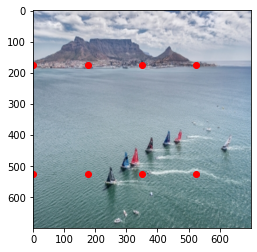

In [5]:
image_test = Image.open(path_mer + 'cvs76.jpg')
image_test = img_format(image_test)
plt.imshow(image_test)
plt.scatter(get_patch_coordinates(700, 700, n_target, p_size)[0], get_patch_coordinates(700, 700, n_target, p_size)[1],
            c='r')

# Receuil des données

In [5]:
def rotationally_invariant_measure(image, distances, levels, measure):
    DIRECTIONS = [0, np.pi / 4, np.pi / 2, (3 * np.pi) / 4]
    GLCMs = greycomatrix(image, distances=distances, angles=DIRECTIONS, levels=levels, symmetric=True, normed=True)
    return np.sum(greycoprops(GLCMs, measure))

On vas extraire les patchs et faire un vote majoritaire sur leur classes prédites pour classifier l'image associée.

In [6]:
import model

model._path_mer = "../Data/mer/"
model._path_ailleurs = "../Data/Ailleurs/"


class ImageTexturesMBD(model.MultiInstanceBaseDescriptor):

    def __init__(self, measures, p_size, formatter, patcher, n_target=9, q_factor=4):
        """
        measures : les mesures à calculer dans les GLCMs
        p_size : la taille des patchs à appliquer sur chaque image
        patcher : callable chargé de calculer les coordonnées d'application des patchs. Il prend en entrée la largeur,
                  la hauteur de l'image, le nombre cible de patchs à appliquer et la taille que doit avoir chaque patch.
                  Il retourne un tuple de deux séquences, une pour les x, une pour les y.
        n_target : le nombre de patchs cible
        q_factor : le facteur de quantification à appliquer comme dernière transformation à l'image
        formatter : un callable qui transforme l'image avant d'appliquer les patchs (par exemple si on souhaite faire
                    un zoom. Prend et renvoie une image.
        """
        self.measures = measures
        self.p_size = p_size
        self.q_factor = q_factor
        self.formatter = formatter
        self.patcher = patcher
        super().__init__(n_target, len(measures) + 1)

    def data_collect(self, image_path):
        im = Image.open(image_path)
        if self.formatter is not None:
            image = self.formatter(im).quantize(self.q_factor)
        else:
            image = im.quantize(self.q_factor)
        xs, ys = self.patcher(image.width, image.height, self.n_target, self.p_size)
        n_patch = len(xs)
        patchs_data = []
        for k in range(n_patch):
            data = []
            cx = xs[k]
            cy = ys[k]
            patch = image.crop((cx, cy, cx + self.p_size, cy + self.p_size))
            for measure in self.measures:
                data.append(rotationally_invariant_measure(patch, [1], self.q_factor, measure))
            data.append(shannon_entropy(patch))
            patchs_data.append(data)
        return patchs_data

    def construct_y_model(self):
        self.y_model = [[y] * self.n_target for y in self.y_model]


def predictor(y_predicts):
    sum1 = sum(y_predicts)
    sum0 = len(y_predicts) - sum1
    return 1 if sum1 >= sum0 else 0

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
textureDescriptor = model.TextureDescriptor(
    ['contrast', 'dissimilarity', 'homogeneity'],
    p_size=175,
    q_factor=4,
    formatter=img_format,
    patcher=get_patch_coordinates
)
textureDescriptor.reset()
textureDescriptor.construct()
textureDescriptor.construct_y()

textureDescriptor.n_target = len(textureDescriptor.X_model[0])

constructing model..


100%|██████████| 207/207 [00:22<00:00,  9.31it/s]

done


In [11]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
print(textureDescriptor.train_test_evaluate(classifier=classifier, predicter=predictor, n_iter=50))

evaluating..


100%|██████████| 50/50 [00:00<00:00, 135.34it/s]

done
0.5000615384615384


In [ ]:
textureDescriptor.construct_from_images("Data/Evalaution/")

In [32]:
from joblib import dump

classifier = textureDescriptor.to_fitted_classifier(KNeighborsClassifier(weights="distance"))
dump(classifier, '../comatrixPatch.joblib')

fitting..


['../comatrixPatch.joblib']

Text(0, 0.5, 'entropy')

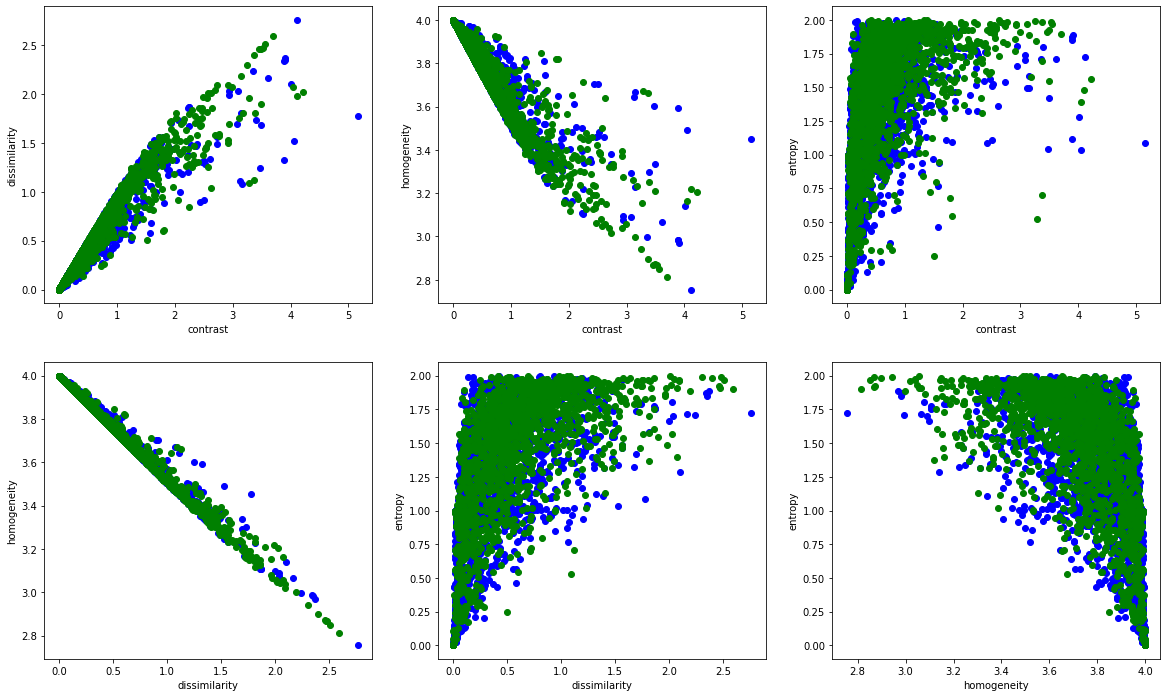

In [22]:
# affichage des données en plot

fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot((231))  # contrast - dissimilarity
ax2 = fig.add_subplot((232))  # contrast - homogeneity
ax3 = fig.add_subplot((233))  # contrast - entropy
ax4 = fig.add_subplot((234))  # dissimilarity - homogeneity
ax5 = fig.add_subplot((235))  # dissimilarity - entropy
ax6 = fig.add_subplot((236))  # homogeneity - entropy

for image_data in textureDescriptor.X_model[:206]:
    for patch_measures in image_data:
        ax1.scatter(patch_measures[0], patch_measures[1], c='b')
        ax2.scatter(patch_measures[0], patch_measures[2], c='b')
        ax3.scatter(patch_measures[0], patch_measures[3], c='b')
        ax4.scatter(patch_measures[1], patch_measures[2], c='b')
        ax5.scatter(patch_measures[1], patch_measures[3], c='b')
        ax6.scatter(patch_measures[2], patch_measures[3], c='b')

for image_data in textureDescriptor.X_model[206:413]:
    for patch_measures in image_data:
        ax1.scatter(patch_measures[0], patch_measures[1], c='g')
        ax2.scatter(patch_measures[0], patch_measures[2], c='g')
        ax3.scatter(patch_measures[0], patch_measures[3], c='g')
        ax4.scatter(patch_measures[1], patch_measures[2], c='g')
        ax5.scatter(patch_measures[1], patch_measures[3], c='g')
        ax6.scatter(patch_measures[2], patch_measures[3], c='g')

dump = ax1.set_xlabel("contrast")
dump = ax2.set_xlabel("contrast")
dump = ax3.set_xlabel("contrast")
dump = ax4.set_xlabel("dissimilarity")
dump = ax5.set_xlabel("dissimilarity")
dump = ax6.set_xlabel("homogeneity")

dump = ax1.set_ylabel("dissimilarity")
dump = ax2.set_ylabel("homogeneity")
dump = ax3.set_ylabel("entropy")
dump = ax4.set_ylabel("homogeneity")
dump = ax5.set_ylabel("entropy")
dump = ax6.set_ylabel("entropy")

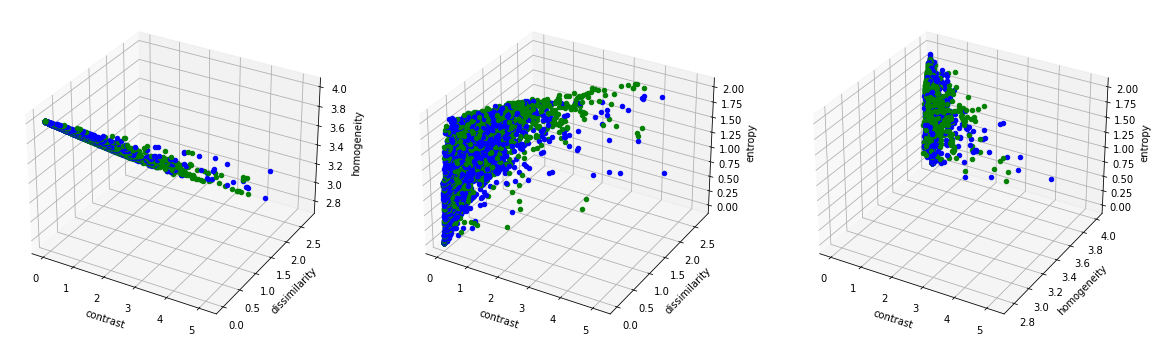

In [24]:
# affichage des données en plot

fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot((131), projection='3d')  # contrast - dissimilarity - homogeneity
ax2 = fig.add_subplot((132), projection='3d')  # contrast - dissimilarity - entropy
ax3 = fig.add_subplot((133), projection='3d')  # contrast - homogeneity - entropy

for image_data in textureDescriptor.X_model[:206]:
    for patch_measures in image_data:
        ax1.scatter(patch_measures[0], patch_measures[1], patch_measures[2], c='b')
        ax2.scatter(patch_measures[0], patch_measures[1], patch_measures[3], c='b')
        ax3.scatter(patch_measures[0], patch_measures[2], patch_measures[3], c='b')

for image_data in textureDescriptor.X_model[206:413]:
    for patch_measures in image_data:
        ax1.scatter(patch_measures[0], patch_measures[1], patch_measures[2], c='g')
        ax2.scatter(patch_measures[0], patch_measures[1], patch_measures[3], c='g')
        ax3.scatter(patch_measures[0], patch_measures[2], patch_measures[3], c='g')

dump = ax1.set_xlabel("contrast")
dump = ax2.set_xlabel("contrast")
dump = ax3.set_xlabel("contrast")

dump = ax1.set_ylabel("dissimilarity")
dump = ax2.set_ylabel("dissimilarity")
dump = ax3.set_ylabel("homogeneity")

dump = ax1.set_zlabel("homogeneity")
dump = ax2.set_zlabel("entropy")
dump = ax3.set_zlabel("entropy")

plt.show()